## Predikcija slova znakovnog jezika

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

Ucitavamo i predprocesiramo podatke:

In [2]:
train_data = pd.read_csv("../projekat/data/sign_mnist_train/sign_mnist_train.csv")
test_data = pd.read_csv("../projekat/data/sign_mnist_test/sign_mnist_test.csv")

y_train = train_data['label'] #slova
x_train = train_data.drop(["label"],axis=1) #slika


y_test = test_data['label']
x_test = test_data.drop(["label"],axis=1)

label_binrizer = LabelBinarizer()
y_train = label_binrizer.fit_transform(y_train)
y_test = label_binrizer.fit_transform(y_test)

# normalizacija
x_train = x_train/255.0
x_test = x_test/255.0

# reshape
x_train = x_train.values.reshape(-1,28,28,1)
x_test = x_test.values.reshape(-1,28,28,1)

Trening podaci su podeljeni na trening i validacione u odnosu 80/20 i bice korisceni za obucavanje modela. 

In [3]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=42)

In [4]:
print("x_train shape",x_train.shape)
print("x_val shape",x_val.shape)
print("y_train shape",y_train.shape)
print("y_val shape",y_val.shape)

x_train shape (21964, 28, 28, 1)
x_val shape (5491, 28, 28, 1)
y_train shape (21964, 24)
y_val shape (5491, 24)


In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization

Za brze treniranje mreze i lakse inicijalizovanje tezina, koristi se [**BatchNormalization**](https://keras.io/api/layers/normalization_layers/batch_normalization/). 



In [6]:
# building a linear stack of layers with the sequential model
model = Sequential()

# convolutional layer
model.add(Conv2D(32 , (3,3) , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
# convolutional layer
model.add(Conv2D(64 , (3,3) , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
# convolutional layer
model.add(Conv2D(128, (3,3) , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))

# flatten output of conv
model.add(BatchNormalization())
model.add(Flatten())

# hidden layer
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(units = 24 , activation = 'softmax'))

# compiling the sequential model
model.compile(optimizer = Adam(lr=0.001) , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         7

In [8]:
from keras.callbacks import ModelCheckpoint
from datetime import datetime

checkpointer = ModelCheckpoint(filepath="models/best_weights.hdf5", verbose=1, save_best_only=True) 

start = datetime.now()
history = model.fit(x_train, y_train, batch_size=128, epochs=15, validation_data=(x_val, y_val), 
          callbacks=[checkpointer], verbose=1)

duration = datetime.now() - start
print("Training completed in: ", duration)

Epoch 1/15
172/172 [==============================] - 105s 590ms/step - loss: 1.4878 - accuracy: 0.6022 - val_loss: 4.2664 - val_accuracy: 0.0368

Epoch 00001: val_loss improved from inf to 4.26642, saving model to models\best_weights.hdf5
Epoch 2/15
172/172 [==============================] - 112s 650ms/step - loss: 0.0373 - accuracy: 0.9978 - val_loss: 3.1540 - val_accuracy: 0.1502

Epoch 00002: val_loss improved from 4.26642 to 3.15404, saving model to models\best_weights.hdf5
Epoch 3/15
172/172 [==============================] - 159s 924ms/step - loss: 0.0106 - accuracy: 0.9999 - val_loss: 0.3925 - val_accuracy: 0.8929

Epoch 00003: val_loss improved from 3.15404 to 0.39250, saving model to models\best_weights.hdf5
Epoch 4/15
172/172 [==============================] - 155s 903ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.0038 - val_accuracy: 1.0000

Epoch 00004: val_loss improved from 0.39250 to 0.00381, saving model to models\best_weights.hdf5
Epoch 5/15
172/172 [========

In [9]:
train_score = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: ", train_score[1])

test_score = model.evaluate(x_val, y_val, verbose=1)
print("Validation Accuracy: ", test_score[1])

test_score = model.evaluate(x_test, y_test, verbose=1)
print("Test Accuracy: ", test_score[1])

687/687 [==============================] - 37s 54ms/step - loss: 6.6340e-06 - accuracy: 1.0000
Training Accuracy:  1.0
172/172 [==============================] - 9s 50ms/step - loss: 1.0140e-05 - accuracy: 1.0000
Validation Accuracy:  1.0
225/225 [==============================] - 14s 60ms/step - loss: 0.1979 - accuracy: 0.9446
Test Accuracy:  0.9446458220481873


In [11]:
y_pred = model.predict(x_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred.round())

0.9393474623535973

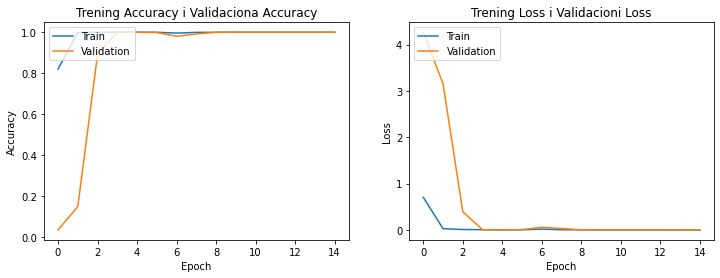

In [10]:
import matplotlib.pyplot as pltS

fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Trening Accuracy i Validaciona Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Trening Loss i Validacioni Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

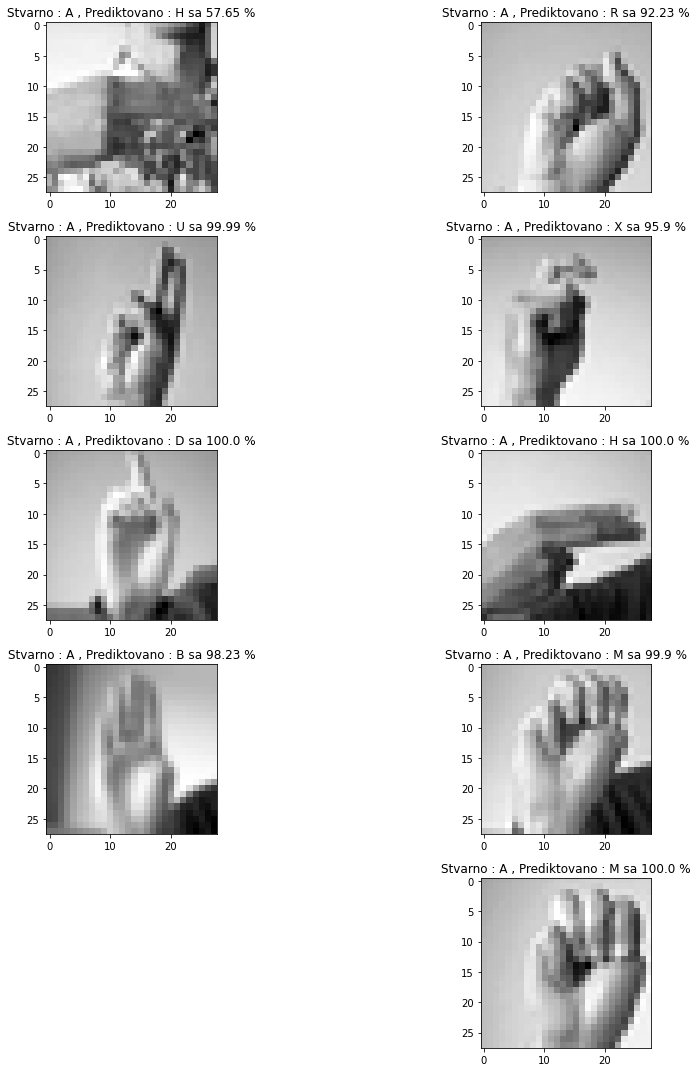

In [23]:
num_letters = {0 : 'A' , 1 : 'B', 2 : 'C' , 3 : 'D', 4: 'E' , 5 : 'F',
                     6 : 'G' , 7 : 'H' , 8 : 'I' , 9 : 'K' , 
                     10 : 'L' , 11 :'M' , 12 : 'N' , 13 : 'O' , 14 : 'P',
                     15 : 'Q' , 16 : 'R' , 17 : 'S' , 18 :'T' , 19 : 'U',
                     20 : 'V' , 21 :'W' , 22 : 'X', 23 : 'Y'}


y_pred = model.predict(x_test)

y_pred2 = np.array([np.argmax(y_pred[i]) for i in range(len(y_pred))])
y_test2 = np.array([np.argmax(y_test[i]) for i in range(len(y_test))])


plt.figure(figsize = (15,15))
for i in range(10):
    ind = np.random.randint(0,len(x_test))
    plt.subplot(5,2,i+1)
    plt.imshow(x_test[ind].reshape(28,28),cmap="gray")
    plt.title('Stvarno : {} , Prediktovano : {} sa {} %'.format(num_letters[y_test2[ind]],
                                                                num_letters[y_pred2[ind]],
                                                                round(y_pred[ind][y_pred2[ind]]*100,2)))
    plt.tight_layout()  